# Clustering Crypto

In [1006]:
# Initial imports
import requests
import pandas as pd
import matplotlib.pyplot as plt
import hvplot.pandas
import plotly.express as px
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import os
from dotenv import load_dotenv

### Fetching Cryptocurrency Data

In [1007]:
# Use the following endpoint to fetch json data
load_dotenv()

url = "https://min-api.cryptocompare.com/data/all/coinlist"

api_key = os.getenv("CRYPTOCOMPARE_API_KEY")

payload = {
    "api_key": api_key
}

result = requests.get(url, params=payload).json()

df = pd.DataFrame(result['Data'])

In [1008]:
# Create a DataFrame 
# HINT: You will need to use the 'Data' key from the json response, then transpose the DataFrame.
df_transposed = df.T
df_transposed.head()

,Algorithm,AssetLaunchDate,AssetTokenStatus,BlockNumber,BlockReward,BlockTime,BuiltOn,CoinName,ContentCreatedOn,DecimalPoints,...,PlatformType,ProofType,Rating,SmartContractAddress,SortOrder,Sponsored,Symbol,Taxonomy,TotalCoinsMined,Url
42,Scrypt,0000-00-00,N/A,0,0,0,NaN,42 Coin,1427211129,NaN,...,NaN,PoW/PoS,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",NaN,34,False,42,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",0,/coins/42/overview
300,N/A,2017-07-01,N/A,0,0,0,ETH,300 token,1517935016,18,...,token,N/A,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",0xaec98a708810414878c3bcdf46aad31ded4a4557,2212,False,300,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",300,/coins/300/overview
365,X11,0000-00-00,N/A,0,0,0,NaN,365Coin,1480032918,NaN,...,NaN,PoW/PoS,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",NaN,916,False,365,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",0,/coins/365/overview
404,Scrypt,0000-00-00,N/A,0,0,0,NaN,404Coin,1466100361,NaN,...,NaN,PoW/PoS,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",NaN,602,False,404,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",0,/coins/404/overview
433,N/A,NaN,Finished,NaN,NaN,NaN,NaN,433 Token,1541597321,NaN,...,NaN,N/A,"{'Weiss': {'Rating': '', 'TechnologyAdoptionRa...",NaN,3505,False,433,"{'Access': '', 'FCA': '', 'FINMA': '', 'Indust...",NaN,/coins/433/overview


In [1009]:
# Alternatively, use the provided csv file:
from pathlib import Path
file_path = Path("Resources/crypto_data.csv")
file_df = pd.read_csv(file_path, encoding="ISO-8859-1", index_col=0)
file_df.head()

,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


### Data Preprocessing

In [1010]:
# Keep only necessary columns:
# 'CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply'
columns = ['CoinName','Algorithm','IsTrading','ProofType','TotalCoinsMined','TotalCoinSupply']

#coin_list = df_transposed[columns]
#column TotalCoinSupply does not exist in the API return data. so using data file.
coin_list = file_df
list(coin_list.columns) 

['CoinName',
 'Algorithm',
 'IsTrading',
 'ProofType',
 'TotalCoinsMined',
 'TotalCoinSupply']

In [1011]:
# Keep only cryptocurrencies that are trading
trading_coin_list = coin_list[coin_list["IsTrading"] == True]
print(trading_coin_list.IsTrading.unique())
trading_coin_list.head()

[ True]


,CoinName,Algorithm,IsTrading,ProofType,TotalCoinsMined,TotalCoinSupply
42,42 Coin,Scrypt,True,PoW/PoS,4.199995e+01,42
365,365Coin,X11,True,PoW/PoS,NaN,2300000000
404,404Coin,Scrypt,True,PoW/PoS,1.055185e+09,532000000
611,SixEleven,SHA-256,True,PoW,NaN,611000
808,808,SHA-256,True,PoW/PoS,0.000000e+00,0


In [1012]:
# Keep only cryptocurrencies with a working algorithm
trading_coin_list = trading_coin_list[trading_coin_list['Algorithm'].notna()]
#trading_coin_list.Algorithm.unique()

In [1013]:
# Remove the "IsTrading" column
trading_coin_list = trading_coin_list.drop(['IsTrading'], axis=1).copy()
list(trading_coin_list.columns)

['CoinName', 'Algorithm', 'ProofType', 'TotalCoinsMined', 'TotalCoinSupply']

In [1014]:
# Remove rows with at least 1 null value
trading_coin_list.dropna(inplace = True)
list(trading_coin_list.columns)

['CoinName', 'Algorithm', 'ProofType', 'TotalCoinsMined', 'TotalCoinSupply']

In [1015]:
# Remove rows with cryptocurrencies having no coins mined
trading_coin_list = trading_coin_list[trading_coin_list.TotalCoinsMined > 0]
list(trading_coin_list.columns)

['CoinName', 'Algorithm', 'ProofType', 'TotalCoinsMined', 'TotalCoinSupply']

In [1016]:
# Drop rows where there are 'N/A' text values
trading_coin_list = trading_coin_list[trading_coin_list["CoinName"] != "N/A"]
trading_coin_list = trading_coin_list[trading_coin_list["Algorithm"] != "N/A"] 
trading_coin_list = trading_coin_list[trading_coin_list["ProofType"] != "N/A"] 
trading_coin_list = trading_coin_list[trading_coin_list["TotalCoinsMined"] != "N/A"] 
trading_coin_list = trading_coin_list[trading_coin_list["TotalCoinSupply"] != "N/A"] 
list(trading_coin_list.columns)

['CoinName', 'Algorithm', 'ProofType', 'TotalCoinsMined', 'TotalCoinSupply']

In [1017]:
# Store the 'CoinName'column in its own DataFrame prior to dropping it from crypto_df
coin_names = trading_coin_list['CoinName']

In [1018]:
# Drop the 'CoinName' column since it's not going to be used on the clustering algorithm
trading_coin_list = trading_coin_list.drop(['CoinName'], axis=1).copy()
list(trading_coin_list.columns)
trading_coin_list.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply
42,Scrypt,PoW/PoS,4.199995e+01,42
404,Scrypt,PoW/PoS,1.055185e+09,532000000
1337,X13,PoW/PoS,2.927942e+10,314159265359
BTC,SHA-256,PoW,1.792718e+07,21000000
ETH,Ethash,PoW,1.076842e+08,0


In [1019]:
# Create dummy variables for text features
trading_coin_list_encoded = pd.get_dummies(trading_coin_list, columns=["Algorithm", "ProofType"])
trading_coin_list_encoded.head()

,TotalCoinsMined,TotalCoinSupply,Algorithm_1GB AES Pattern Search,Algorithm_536,Algorithm_Argon2d,Algorithm_BLAKE256,Algorithm_Blake,Algorithm_Blake2S,Algorithm_Blake2b,Algorithm_C11,...,ProofType_PoW/PoS,ProofType_PoW/PoS,ProofType_PoW/PoW,ProofType_PoW/nPoS,ProofType_Pos,ProofType_Proof of Authority,ProofType_Proof of Trust,ProofType_TPoS,ProofType_Zero-Knowledge Proof,ProofType_dPoW/PoW
42,4.199995e+01,42,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
404,1.055185e+09,532000000,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1337,2.927942e+10,314159265359,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
BTC,1.792718e+07,21000000,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ETH,1.076842e+08,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [1020]:
# Standardize data
trading_coin_list_scaled = StandardScaler().fit_transform(trading_coin_list_encoded)
print(trading_coin_list_scaled[0:2])

[[-0.11710817 -0.1528703  -0.0433963  -0.0433963  -0.0433963  -0.06142951
  -0.07530656 -0.0433963  -0.06142951 -0.06142951 -0.0433963  -0.0433963
  -0.19245009 -0.06142951 -0.09740465 -0.0433963  -0.11547005 -0.07530656
  -0.0433963  -0.0433963  -0.15191091 -0.0433963  -0.13118084 -0.0433963
  -0.0433963  -0.08703883 -0.0433963  -0.0433963  -0.0433963  -0.0433963
  -0.06142951 -0.0433963  -0.08703883 -0.08703883 -0.08703883 -0.0433963
  -0.13118084 -0.13840913 -0.13840913 -0.0433963  -0.06142951 -0.0433963
  -0.07530656 -0.18168574 -0.0433963  -0.0433963  -0.0433963  -0.07530656
  -0.15826614 -0.31491833 -0.0433963  -0.08703883 -0.07530656 -0.06142951
   1.38675049 -0.0433963  -0.0433963  -0.06142951 -0.0433963  -0.0433963
  -0.0433963  -0.0433963  -0.0433963  -0.0433963  -0.0433963  -0.0433963
  -0.39879994 -0.0433963  -0.18168574 -0.0433963  -0.08703883 -0.08703883
  -0.10680283 -0.0433963  -0.13118084 -0.0433963  -0.0433963  -0.0433963
  -0.0433963  -0.07530656 -0.43911856 -0.04339

### Reducing Dimensions Using PCA

In [1021]:
# Use PCA to reduce dimensions to 3 principal components
# Initialize PCA model
pca = PCA(n_components=3)

# Get two principal components for the data.
trading_coin_list_pca = pca.fit_transform(trading_coin_list_scaled)

In [1022]:
new_coin_names = coin_names.reset_index()
new_coin_names.head()

,index,CoinName
0,42,42 Coin
1,404,404Coin
2,1337,EliteCoin
3,BTC,Bitcoin
4,ETH,Ethereum


In [1023]:
# Create a DataFrame with the principal components data
df_trading_coin_list_pca = pd.DataFrame(
    data=trading_coin_list_pca, columns=["PC 1", "PC 2", "PC 3"]
)

df_trading_coin_list_pca["Code"] = new_coin_names.iloc[:, 0]
df_trading_coin_list_pca.set_index("Code", inplace = True)
df_trading_coin_list_pca.head()

,PC 1,PC 2,PC 3
Code,,,
42,-0.377585,1.025862,-0.575492
404,-0.361011,1.025811,-0.575924
1337,2.290707,1.565452,-0.682782
BTC,-0.135600,-1.326002,0.188096
ETH,-0.132612,-2.020123,0.361738


In [1024]:
pca.explained_variance_ratio_

array([0.02791788, 0.02138711, 0.02050494])

In [1025]:
# This is a terrible PCA result. So the encoding of Algorithm and ProofType columns has to be done differently instead of just using dummy values.

### Clustering Crytocurrencies Using K-Means

#### Find the Best Value for `k` Using the Elbow Curve

In [1026]:
inertia = []
k = list(range(1, 11))

# Calculate the inertia for the range of k values
for i in k:
    km = KMeans(n_clusters=i, random_state=0)
    km.fit(trading_coin_list_scaled)
    inertia.append(km.inertia_)

# Create the Elbow Curve using hvPlot
elbow_data = {"k": k, "inertia": inertia}
df_elbow = pd.DataFrame(elbow_data)
df_elbow.hvplot.line(x="k", y="inertia", xticks=k, title="Elbow Curve")

:Curve   [k]   (inertia)

In [1027]:
# Not very obvious. The best value looks like 8.

Running K-Means with `k=<your best value for k here>`

In [1028]:
new_trading_coin_list = pd.concat([trading_coin_list, df_trading_coin_list_pca, coin_names], axis=1, sort=False)
new_trading_coin_list.head()

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,CoinName
Code,,,,,,,,
42,Scrypt,PoW/PoS,4.199995e+01,42,-0.377585,1.025862,-0.575492,42 Coin
404,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.361011,1.025811,-0.575924,404Coin
1337,X13,PoW/PoS,2.927942e+10,314159265359,2.290707,1.565452,-0.682782,EliteCoin
BTC,SHA-256,PoW,1.792718e+07,21000000,-0.135600,-1.326002,0.188096,Bitcoin
ETH,Ethash,PoW,1.076842e+08,0,-0.132612,-2.020123,0.361738,Ethereum


In [1029]:
# Initialize the K-Means model
model = KMeans(n_clusters=8, random_state=0)

# Fit the model
model.fit(trading_coin_list_scaled)

# Predict clusters
predictions = model.predict(trading_coin_list_scaled)

# Create a new DataFrame including predicted clusters and cryptocurrencies features
new_trading_coin_list["class"] = model.labels_
new_trading_coin_list.head(10)

,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,PC 1,PC 2,PC 3,CoinName,class
Code,,,,,,,,,
42,Scrypt,PoW/PoS,4.199995e+01,42,-0.377585,1.025862,-0.575492,42 Coin,0
404,Scrypt,PoW/PoS,1.055185e+09,532000000,-0.361011,1.025811,-0.575924,404Coin,0
1337,X13,PoW/PoS,2.927942e+10,314159265359,2.290707,1.565452,-0.682782,EliteCoin,2
BTC,SHA-256,PoW,1.792718e+07,21000000,-0.135600,-1.326002,0.188096,Bitcoin,0
ETH,Ethash,PoW,1.076842e+08,0,-0.132612,-2.020123,0.361738,Ethereum,0
LTC,Scrypt,PoW,6.303924e+07,84000000,-0.192544,-1.094629,-0.008931,Litecoin,0
DASH,X11,PoW/PoS,9.031294e+06,22000000,-0.377371,1.187994,-0.507241,Dash,2
XMR,CryptoNight-V7,PoW,1.720114e+07,0,-0.155723,-2.249465,0.501038,Monero,0
ETC,Ethash,PoW,1.133597e+08,210000000,-0.131062,-2.020241,0.361718,Ethereum Classic,0


### Visualizing Results

#### 3D-Scatter with Clusters

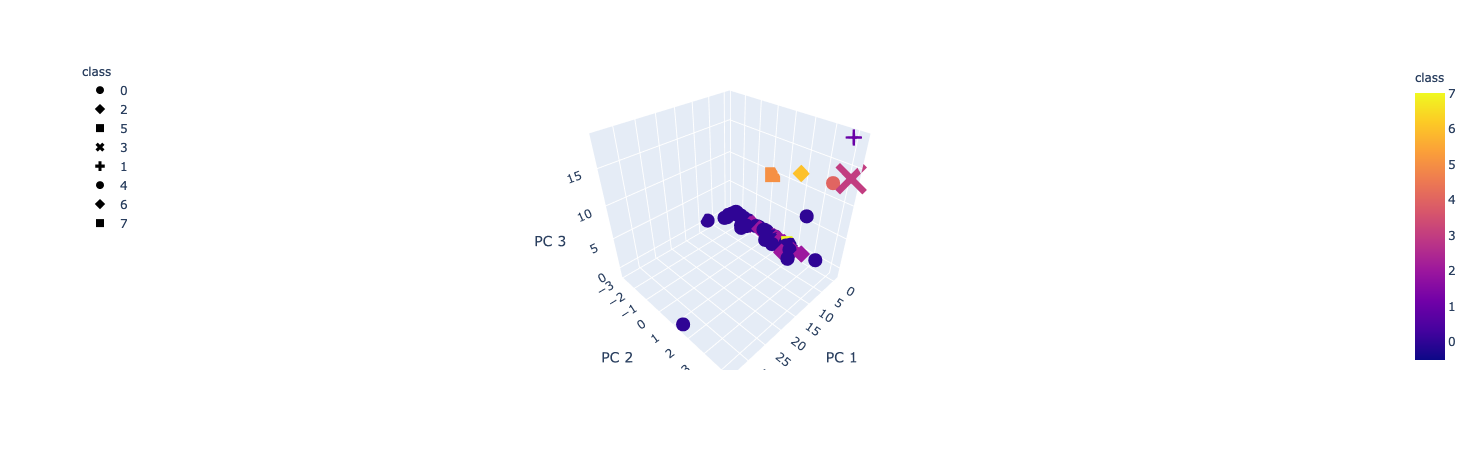

In [1030]:
# Create a 3D-Scatter with the PCA data and the clusters
fig = px.scatter_3d(
    new_trading_coin_list,
    x="PC 1",
    y="PC 2",
    z="PC 3",
    color="class",
    symbol="class",
    width=800,
)
fig.update_layout(legend=dict(x=0, y=1))
fig.show()

#### Table of Tradable Cryptocurrencies

In [1031]:
# Table with tradable cryptos

tradable_coin_list = new_trading_coin_list.drop(['PC 1', 'PC 2', 'PC 3'], axis=1)

tradable_coin_list = tradable_coin_list[['CoinName', 'Algorithm', 'ProofType', 'TotalCoinsMined', 'TotalCoinSupply', 'class']]

tradable_coin_list.head(10)

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,class
Code,,,,,,
42,42 Coin,Scrypt,PoW/PoS,4.199995e+01,42,0
404,404Coin,Scrypt,PoW/PoS,1.055185e+09,532000000,0
1337,EliteCoin,X13,PoW/PoS,2.927942e+10,314159265359,2
BTC,Bitcoin,SHA-256,PoW,1.792718e+07,21000000,0
ETH,Ethereum,Ethash,PoW,1.076842e+08,0,0
LTC,Litecoin,Scrypt,PoW,6.303924e+07,84000000,0
DASH,Dash,X11,PoW/PoS,9.031294e+06,22000000,2
XMR,Monero,CryptoNight-V7,PoW,1.720114e+07,0,0
ETC,Ethereum Classic,Ethash,PoW,1.133597e+08,210000000,0


In [1032]:
# Print the total number of tradable cryptocurrencies
tradable_coin_list_table = tradable_coin_list.hvplot.table()
tradable_coin_list_table

:Table   [CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,class]

#### Scatter Plot with Tradable Cryptocurrencies

In [1033]:
# Scale data to create the scatter plot
import numpy as np

tradable_coin_list.loc[tradable_coin_list.TotalCoinsMined == "0", 'TotalCoinsMined'] = 1
tradable_coin_list['TotalCoinsMined'] = tradable_coin_list['TotalCoinsMined'].astype(float)

tradable_coin_list.loc[tradable_coin_list.TotalCoinSupply == "0", 'TotalCoinSupply'] = 1
tradable_coin_list['TotalCoinSupply'] = tradable_coin_list['TotalCoinSupply'].astype(float)

tradable_coin_list['TotalCoinsMined'] = np.log10(tradable_coin_list['TotalCoinsMined'])
tradable_coin_list['TotalCoinSupply'] = np.log10(tradable_coin_list['TotalCoinSupply'])


tradable_coin_list.head(10)

,CoinName,Algorithm,ProofType,TotalCoinsMined,TotalCoinSupply,class
Code,,,,,,
42,42 Coin,Scrypt,PoW/PoS,1.623249,1.623249,0
404,404Coin,Scrypt,PoW/PoS,9.023329,8.725912,0
1337,EliteCoin,X13,PoW/PoS,10.466563,11.497150,2
BTC,Bitcoin,SHA-256,PoW,7.253512,7.322219,0
ETH,Ethereum,Ethash,PoW,8.032152,0.000000,0
LTC,Litecoin,Scrypt,PoW,7.799611,7.924279,0
DASH,Dash,X11,PoW/PoS,6.955750,7.342423,2
XMR,Monero,CryptoNight-V7,PoW,7.235557,0.000000,0
ETC,Ethereum Classic,Ethash,PoW,8.054459,8.322219,0


In [1034]:
# Plot the scatter with x="TotalCoinsMined" and y="TotalCoinSupply"
tradable_coin_list.hvplot.scatter(x="TotalCoinsMined", y="TotalCoinSupply", hover_cols=["CoinName"], by="class")

:NdOverlay   [class]
   :Scatter   [TotalCoinsMined]   (TotalCoinSupply,CoinName)